# Music Genre Classifier using XGBoost

Accuracy ~91.09%

## Data Preprocessing

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import optuna
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Data/features_3_sec.csv')
df.drop(columns=['filename', 'length'], inplace=True)
df['label'] = LabelEncoder().fit_transform(df['label'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         9990 non-null   float64
 1   chroma_stft_var          9990 non-null   float64
 2   rms_mean                 9990 non-null   float64
 3   rms_var                  9990 non-null   float64
 4   spectral_centroid_mean   9990 non-null   float64
 5   spectral_centroid_var    9990 non-null   float64
 6   spectral_bandwidth_mean  9990 non-null   float64
 7   spectral_bandwidth_var   9990 non-null   float64
 8   rolloff_mean             9990 non-null   float64
 9   rolloff_var              9990 non-null   float64
 10  zero_crossing_rate_mean  9990 non-null   float64
 11  zero_crossing_rate_var   9990 non-null   float64
 12  harmony_mean             9990 non-null   float64
 13  harmony_var              9990 non-null   float64
 14  perceptr_mean           

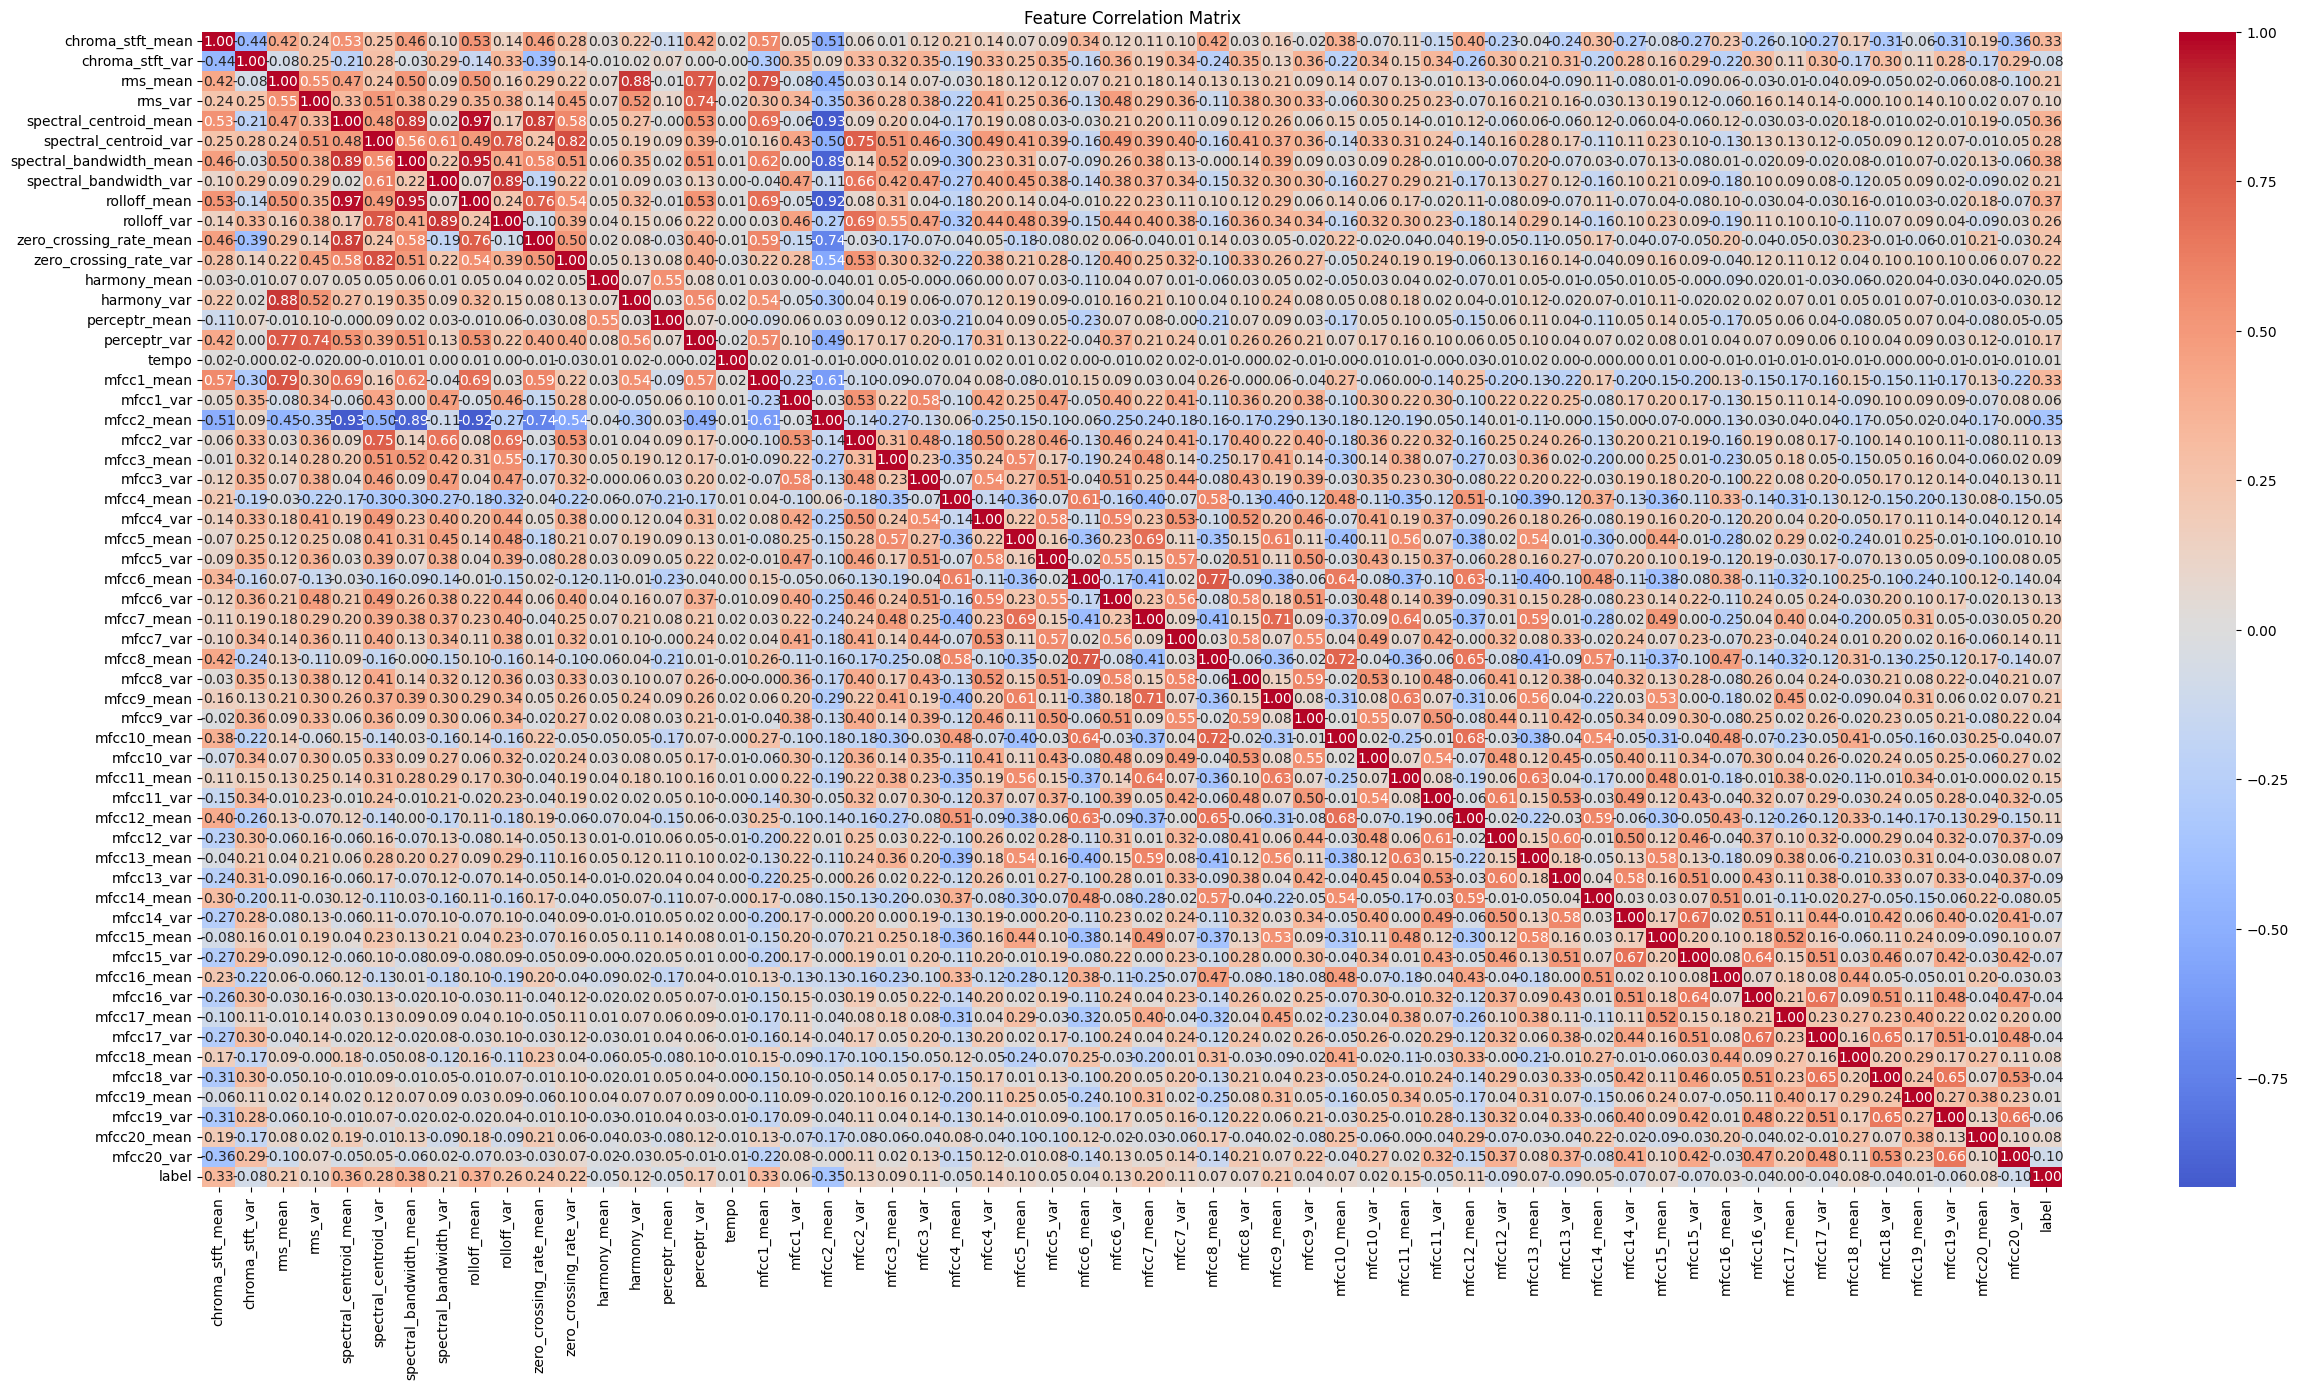

In [3]:
# Plot heatmap
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

In [4]:
def expand_features(df):
    base = df.copy()
    if 'label' in base.columns: base = base.drop(columns=['label'])
    transformed = []

    for col in base.columns:
        base[col] = base[col].astype(float)
        safe = base[col].clip(lower=1e-6)
        transformed.append(pd.DataFrame({f'{col}_squared': safe ** 2, f'{col}_sqrt': np.sqrt(safe), f'{col}_log': np.log1p(safe)}))

    df_expanded = pd.concat([base] + transformed, axis=1)
    return df_expanded

#X = expand_features(df)
X = df.drop(columns=['label'])
y = df["label"]

In [5]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=69)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Modelling

In [26]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step = 20),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 0.1),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 2),
    }

    model = XGBClassifier(eval_metric="mlogloss", early_stopping_rounds=10, **params)

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

[I 2025-06-17 03:27:49,207] A new study created in memory with name: no-name-f90b422e-e989-44b3-bd62-ed5403193e12
[I 2025-06-17 03:27:57,337] Trial 0 finished with value: 0.8703703703703703 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.24847744869313487, 'subsample': 0.6690414795722549, 'colsample_bytree': 0.9429244236544084, 'gamma': 0.4791985437523014, 'reg_alpha': 0.033822085755482456, 'reg_lambda': 1.1136987889364331}. Best is trial 0 with value: 0.8703703703703703.
[I 2025-06-17 03:28:21,812] Trial 1 finished with value: 0.8218218218218218 and parameters: {'n_estimators': 440, 'max_depth': 5, 'learning_rate': 0.012113055242313457, 'subsample': 0.7118976712810566, 'colsample_bytree': 0.8412332984614214, 'gamma': 0.18243197837746283, 'reg_alpha': 0.05095878267612972, 'reg_lambda': 1.9280791242830775}. Best is trial 0 with value: 0.8703703703703703.
[I 2025-06-17 03:28:39,377] Trial 2 finished with value: 0.8978978978978979 and parameters: {'n_estimators':

Best Parameters: {'n_estimators': 940, 'max_depth': 6, 'learning_rate': 0.03699455140068754, 'subsample': 0.774198654617587, 'colsample_bytree': 0.9304117189213128, 'gamma': 0.030184818196461485, 'reg_alpha': 0.050138790208572856, 'reg_lambda': 1.2307878983814329}
Best Validation Accuracy: 0.9109109109109109


In [39]:
model = XGBClassifier(
	n_estimators=940,
	max_depth=6,
	learning_rate=0.03699455140068754,
	subsample=0.774198654617587,
	colsample_bytree=0.9304117189213128,
	gamma=0.030184818196461485,
	reg_alpha=0.050138790208572856,
	reg_lambda=1.2307878983814329,
	eval_metric='mlogloss',
	random_state=69
)
model.fit(X_scaled, y)

joblib.dump(model, "xgb_classifier.pkl")

['xgb_classifier.pkl']

## Deployment

In [6]:
def extract_audio_features(file_path, sample_rate=22050, num_mfcc=20, n_fft=2048, hop_length=512):
    features = {}

    y, sr = librosa.load(file_path, sr=sample_rate)

    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    features["chroma_stft_mean"] = chromagram.mean()
    features["chroma_stft_var"] = chromagram.var()

    rmse = librosa.feature.rms(y=y)
    features["rms_mean"] = rmse.mean()
    features["rms_var"] = rmse.var()

    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    features["spectral_centroid_mean"] = spec_cent.mean()
    features["spectral_centroid_var"] = spec_cent.var()

    spec_band = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features["spectral_bandwidth_mean"] = spec_band.mean()
    features["spectral_bandwidth_var"] = spec_band.var()

    spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features["rolloff_mean"] = spec_roll.mean()
    features["rolloff_var"] = spec_roll.var()

    zero_crossing = librosa.feature.zero_crossing_rate(y=y)
    features["zero_crossing_rate_mean"] = zero_crossing.mean()
    features["zero_crossing_rate_var"] = zero_crossing.var()

    harmony, perceptr = librosa.effects.hpss(y=y)
    features["harmony_mean"] = harmony.mean()
    features["harmony_var"] = harmony.var()
    features["perceptr_mean"] = perceptr.mean()
    features["perceptr_var"] = perceptr.var()

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features["tempo"] = tempo

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    for i in range(num_mfcc):
        features[f"mfcc{i+1}_mean"] = mfcc[i].mean()
        features[f"mfcc{i+1}_var"] = mfcc[i].var()

    return pd.DataFrame([features])

scaler = joblib.load('scaler.pkl')
model = joblib.load("xgb_classifier.pkl")

df = extract_audio_features('Data/genres_original/metal/metal.00007.wav')
df = scaler.transform(df)

predictions = model.predict(df)
genres = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
print(f"The predicted genre for the uploaded audio file is {genres[predictions[0]]}.")

The predicted genre for the uploaded audio file is metal.
